In [3]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm

# Feature extraction & ML models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Handle class imbalance
from imblearn.over_sampling import SMOTE

# Download necessary NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

print("Libraries successfully imported!")

Libraries successfully imported!


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [4]:
# Load dataset
df = pd.read_csv("byakh.csv")

# Display first few rows
print(df.head())

# Check dataset info
print(df.info())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

                                       product_title  rating  \
0       OnePlus Bullets Wireless Z Bluetooth Headset       5   
1                   BoAt BassHeads 100 Wired Headset       4   
2                   BoAt BassHeads 100 Wired Headset       4   
3  OnePlus Bullets Wireless Z Bass Edition Blueto...       4   
4                   BoAt BassHeads 100 Wired Headset       4   

              summary                                             review  \
0           Wonderful  THIS IS THE BEST AND BEST PRODUCT I'VE EVER US...   
1           Wonderful  looks wise it's so good. works properly  defin...   
2  Good at this price  It has better grip than others in the ears. On...   
3         Good choice  Super delivery within one day. Thaks for the f...   
4           Wonderful  build quality is good and sound is also good a...   

  Sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567


In [5]:
# Drop missing reviews
df = df.dropna(subset=["review"])

# Convert rating to numeric
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df = df.dropna(subset=["rating"])

# Convert sentiment labels if needed
def classify_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating ==3:
        return "Neutral"
    else:
        return "Negative"

df["sentiment"] = df["rating"].apply(classify_sentiment)

print(df["sentiment"].value_counts())  # Check label distribution

sentiment
Positive    3548
Negative    1398
Neutral      622
Name: count, dtype: int64


In [6]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Ensure necessary NLTK data is downloaded
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

def preprocess_text(text):
    """Cleans text by removing punctuation, converting to lowercase, tokenizing, 
    removing stopwords, and applying lemmatization."""
    
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation & special characters
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces

    words = word_tokenize(text)  # Tokenize into words
    stop_words = set(stopwords.words("english"))  # Load stopwords once for efficiency

    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return " ".join(words)

# Enable progress bar for applying function
tqdm.pandas()
df["cleaned_review"] = df["review"].progress_apply(preprocess_text)

print("Text preprocessing complete!")  

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
100%|██████████| 5568/5568 [00:03<00:00, 1471.83it/s]

Text preprocessing complete!


In [7]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))  # Word count

print(df[['review', 'review_length']].head())  # Check new column

                                              review  review_length
0  THIS IS THE BEST AND BEST PRODUCT I'VE EVER US...             38
1  looks wise it's so good. works properly  defin...             17
2  It has better grip than others in the ears. On...             56
3  Super delivery within one day. Thaks for the f...             28
4  build quality is good and sound is also good a...             18


In [8]:
import re
import emoji

def clean_text(text):

     # Remove emojis
    text = emoji.replace_emoji(text, replace="")


    text = re.sub(r"https?://\S+|www\.\S+|ftp://\S+|bit\.ly/\S+", "", text, flags=re.MULTILINE)
    # Remove special characters and extra spaces
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Keep only letters & numbers
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()  

    return text.lower()  # Convert to lowercase

# Apply new cleaning function
df['cleaned_review'] = df['review'].apply(clean_text)

# Verify if links are removed
link_count = df['cleaned_review'].str.contains(r"https?://\S+|www\.\S+", regex=True, case=False).sum()
print(f"Reviews still containing links after cleaning: {link_count}")

Reviews still containing links after cleaning: 0


In [7]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Combine 'summary' and 'review' columns
df["combined_text"] = df["summary"] + " " + df["review"]

# Now proceed with TF-IDF vectorization using unigrams + bigrams
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')  # Unigrams + bigrams
X = vectorizer.fit_transform(df["combined_text"]).toarray()  # Transform combined text

# Labels (Sentiment)
y = df["Sentiment"]

# Check shapes
print(f"✅ Feature Matrix Shape: {X.shape}")
print(f"✅ Labels Shape: {y.shape}")

✅ Feature Matrix Shape: (5568, 5000)
✅ Labels Shape: (5568,)


In [8]:
# Combine summary and review into one column
df["combined_text"] = df["summary"] + " " + df["cleaned_review"]

# Apply TF-IDF with unigrams and bigrams
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  
X = vectorizer.fit_transform(df["combined_text"]).toarray()  # Use combined text
y = df["Sentiment"]  # Labels

print(df.head())

                                       product_title  rating  \
0       OnePlus Bullets Wireless Z Bluetooth Headset       5   
1                   BoAt BassHeads 100 Wired Headset       4   
2                   BoAt BassHeads 100 Wired Headset       4   
3  OnePlus Bullets Wireless Z Bass Edition Blueto...       4   
4                   BoAt BassHeads 100 Wired Headset       4   

              summary                                             review  \
0           Wonderful  THIS IS THE BEST AND BEST PRODUCT I'VE EVER US...   
1           Wonderful  looks wise it's so good. works properly  defin...   
2  Good at this price  It has better grip than others in the ears. On...   
3         Good choice  Super delivery within one day. Thaks for the f...   
4           Wonderful  build quality is good and sound is also good a...   

  Sentiment sentiment                                     cleaned_review  \
0  Positive  Positive  this is the best and best product ive ever use...   
1  Pos

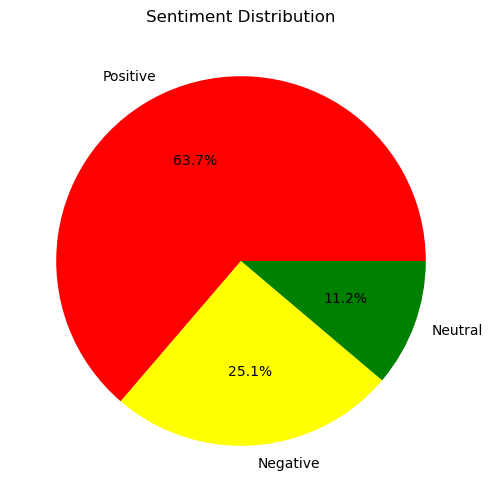

In [9]:
import matplotlib.pyplot as plt

# Count sentiment labels
sentiment_counts = df['Sentiment'].value_counts()

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['red', 'yellow', 'green'])
plt.title("Sentiment Distribution")
plt.show()

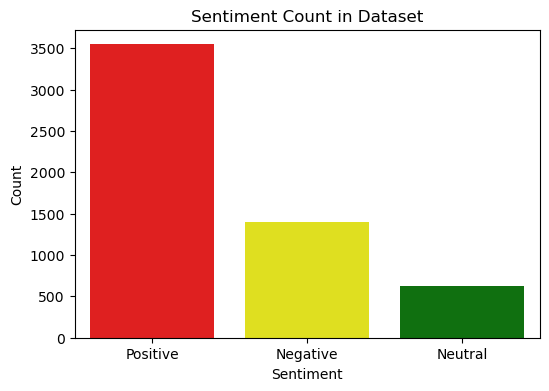

In [10]:
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['red', 'yellow', 'green'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Count in Dataset")
plt.show()

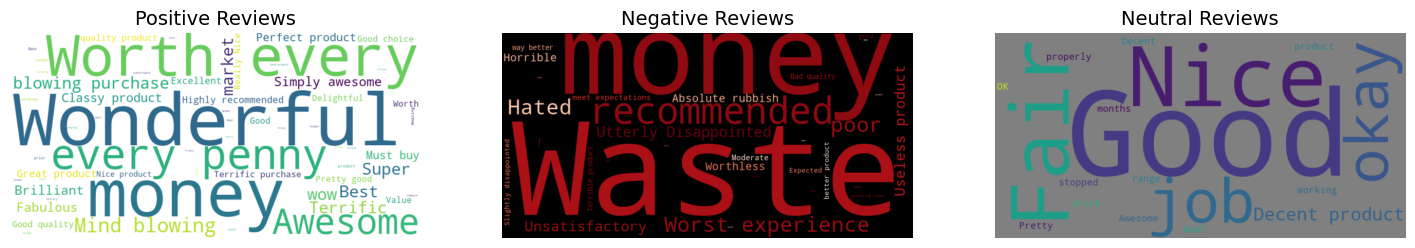

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter reviews based on sentiment
positive_reviews = " ".join(df[df["Sentiment"] == "Positive"]["summary"])
negative_reviews = " ".join(df[df["Sentiment"] == "Negative"]["summary"])
neutral_reviews = " ".join(df[df["Sentiment"] == "Neutral"]["summary"])

# Generate WordClouds
wordcloud_positive = WordCloud(width=800, height=400, background_color="white").generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_reviews)
wordcloud_neutral = WordCloud(width=800, height=400, background_color="gray").generate(neutral_reviews)

# Plot the WordClouds
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews", fontsize=14)

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews", fontsize=14)

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis("off")
plt.title("Neutral Reviews", fontsize=14)

plt.show()

In [12]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Combine 'review' and 'summary' columns
df["combined_text"] = df["summary"] + " " + df["review"]

# Now proceed with TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # Limit vocabulary & remove stop words
X_tfidf = vectorizer.fit_transform(df["combined_text"])  # Transform combined text

# Labels (Sentiment)
y = df["Sentiment"]

# Check shapes
print(f"✅ Feature Matrix Shape: {X_tfidf.shape}")
print(f"✅ Labels Shape: {y.shape}")

✅ Feature Matrix Shape: (5568, 5000)
✅ Labels Shape: (5568,)


In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode Sentiment labels into numerical values
df["Sentiment"] = label_encoder.fit_transform(df["Sentiment"])

# Check the mapping of labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("🔹 Sentiment Label Mapping:", label_mapping)

# Verify changes
df.head()

🔹 Sentiment Label Mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}


,product_title,rating,summary,review,Sentiment,sentiment,cleaned_review,review_length,combined_text
0,OnePlus Bullets Wireless Z Bluetooth Headset,5,Wonderful,THIS IS THE BEST AND BEST PRODUCT I'VE EVER US...,2,Positive,this is the best and best product ive ever use...,38,Wonderful THIS IS THE BEST AND BEST PRODUCT I'...
1,BoAt BassHeads 100 Wired Headset,4,Wonderful,looks wise it's so good. works properly defin...,2,Positive,looks wise its so good works properly definite...,17,Wonderful looks wise it's so good. works prope...
2,BoAt BassHeads 100 Wired Headset,4,Good at this price,It has better grip than others in the ears. On...,2,Positive,it has better grip than others in the ears one...,56,Good at this price It has better grip than oth...
3,OnePlus Bullets Wireless Z Bass Edition Blueto...,4,Good choice,Super delivery within one day. Thaks for the f...,2,Positive,super delivery within one day thaks for the fi...,28,Good choice Super delivery within one day. Tha...
4,BoAt BassHeads 100 Wired Headset,4,Wonderful,build quality is good and sound is also good a...,2,Positive,build quality is good and sound is also good a...,18,Wonderful build quality is good and sound is a...


In [14]:
# Merge 'summary' and 'review' columns into a single text field
df["combined_text"] = df["summary"] + " " + df["review"]

# Initialize TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary
X_tfidf = vectorizer.fit_transform(df["combined_text"])  # Use combined text for vectorization

# Encode Sentiments
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["sentiment"] = label_encoder.fit_transform(df["sentiment"])

# Mapping Sentiment Labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("🔹 Sentiment Label Mapping:", label_mapping)

# Verify Changes
df.head()

🔹 Sentiment Label Mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}


,product_title,rating,summary,review,Sentiment,sentiment,cleaned_review,review_length,combined_text
0,OnePlus Bullets Wireless Z Bluetooth Headset,5,Wonderful,THIS IS THE BEST AND BEST PRODUCT I'VE EVER US...,2,2,this is the best and best product ive ever use...,38,Wonderful THIS IS THE BEST AND BEST PRODUCT I'...
1,BoAt BassHeads 100 Wired Headset,4,Wonderful,looks wise it's so good. works properly defin...,2,2,looks wise its so good works properly definite...,17,Wonderful looks wise it's so good. works prope...
2,BoAt BassHeads 100 Wired Headset,4,Good at this price,It has better grip than others in the ears. On...,2,2,it has better grip than others in the ears one...,56,Good at this price It has better grip than oth...
3,OnePlus Bullets Wireless Z Bass Edition Blueto...,4,Good choice,Super delivery within one day. Thaks for the f...,2,2,super delivery within one day thaks for the fi...,28,Good choice Super delivery within one day. Tha...
4,BoAt BassHeads 100 Wired Headset,4,Wonderful,build quality is good and sound is also good a...,2,2,build quality is good and sound is also good a...,18,Wonderful build quality is good and sound is a...


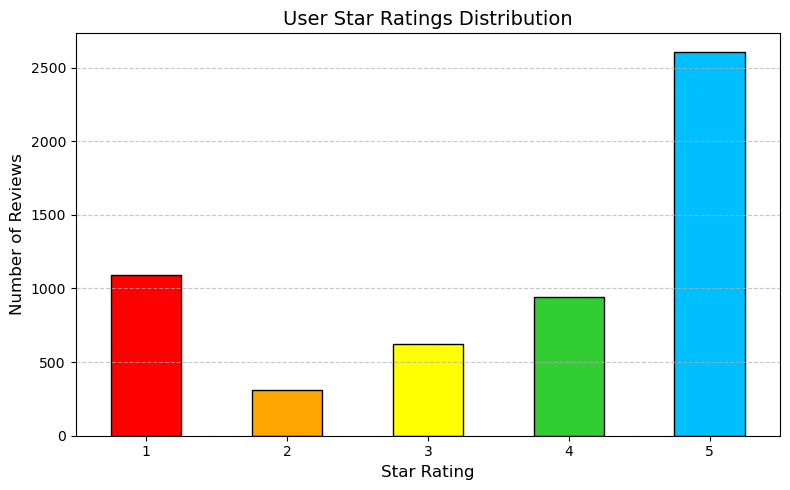

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('byakh.csv')  # Replace with your actual CSV file

# Count the number of each star rating
rating_counts = df['rating'].value_counts().sort_index()

# Define custom colors for each bar (adjust based on number of unique ratings)
colors = ['red', 'orange', 'yellow', 'limegreen', 'deepskyblue']  # For 1 to 5 stars

# Create and save the bar chart
plt.figure(figsize=(8, 5))
rating_counts.plot(kind='bar', color=colors, edgecolor='black')

# Add labels and title
plt.title('User Star Ratings Distribution', fontsize=14)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save as PNG
plt.savefig('colored_star_rating_distribution.png', dpi=300)

# Show the plot
plt.show()


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Transform reviews into numerical vectors
X = vectorizer.fit_transform(df["review"]).toarray()

# Labels (Sentiment)
y = df["sentiment"]

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Combine 'summary' and 'review' for better text representation
df["combined_text"] = df["summary"] + " " + df["review"]

# Initialize TF-IDF Vectorizer (with stop words removal)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Transform text data into numerical vectors
X = vectorizer.fit_transform(df["combined_text"]).toarray()

# Encode Sentiment Labels
label_encoder = LabelEncoder()
df["Sentiment"] = label_encoder.fit_transform(df["Sentiment"])
y = df["Sentiment"]

# Check shapes of feature matrix and labels
print(f"✅ Feature Matrix Shape: {X.shape}")
print(f"✅ Labels Shape: {y.shape}")

✅ Feature Matrix Shape: (5568, 5000)
✅ Labels Shape: (5568,)


In [17]:
# Check Sentiment
from sklearn.model_selection import train_test_split

# Split dataset (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify the shapes
print(f"✅ Training Data Shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"✅ Testing Data Shape: {X_test.shape}, Labels: {y_test.shape}")

✅ Training Data Shape: (4454, 5000), Labels: (4454,)
✅ Testing Data Shape: (1114, 5000), Labels: (1114,)


In [18]:
print(df['Sentiment'].value_counts())  # See available counts

Sentiment
2    3548
0    1398
1     622
Name: count, dtype: int64


In [19]:
from sklearn.neighbors import KNeighborsClassifier

# Check dataset size
print(f"Training samples: {X_train.shape[0]}")

# Ensure n_neighbors is not greater than available samples
n_neighbors = min(5, X_train.shape[0])  # Adjust dynamically

knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_model.fit(X_train, y_train)

# Predict
y_pred = knn_model.predict(X_test)

Training samples: 4454


In [21]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)  # Convert categorical labels to numbers

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2

# Reduce features (keep top 1000 most relevant)
X_train_reduced = SelectKBest(chi2, k=1000).fit_transform(X_train, y_train)
X_test_reduced = SelectKBest(chi2, k=1000).fit_transform(X_test, y_test)

# Define the model
svm_model = SVC(probability=True)

# Reduced parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Keep fewer values
    'gamma': ['scale'],  # Remove 'auto' (faster)
    'kernel': ['linear']  # Remove 'rbf' (rbf is slow for large data)
}

# Use fewer iterations & 2-fold CV
random_search = RandomizedSearchCV(svm_model, param_distributions=param_grid, 
                                   n_iter=2, cv=2, scoring='accuracy', 
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train_reduced, y_train)

# Best parameters
print("Best parameters found:", random_search.best_params_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best parameters found: {'kernel': 'linear', 'gamma': 'scale', 'C': 1}


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Initialize the SVM model with the best parameters
best_svm_model = SVC(C=1, gamma='scale', kernel='linear')

# Fit the model on the training data
best_svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test)

In [26]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

SVM Accuracy: 0.9381
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       280
           1       0.87      0.65      0.74       124
           2       0.93      0.99      0.96       710

    accuracy                           0.94      1114
   macro avg       0.93      0.86      0.89      1114
weighted avg       0.94      0.94      0.93      1114



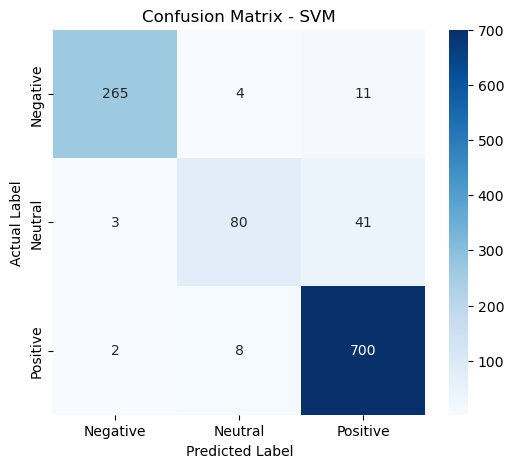

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#Step 4: Compute the Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred)
#Step 5: Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]
#Step 6: Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - SVM")
plt.show()

In [29]:
from imblearn.over_sampling import SMOTE  

smote = SMOTE(random_state=42)  
X_resampled, y_resampled = smote.fit_resample(X, y)  


In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
# Initialize Naïve Bayes Model with Laplace smoothing
nb_model = MultinomialNB(alpha=1)
# Train the model on the balanced dataset
nb_model.fit(X_resampled, y_resampled)
# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test)
# Evaluate model performance
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naïve Bayes Accuracy: {nb_accuracy:.4f}")
# Display classification report
print("Naïve Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))

Naïve Bayes Accuracy: 0.9443
Naïve Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       280
           1       0.74      0.96      0.84       124
           2       0.99      0.95      0.97       710

    accuracy                           0.94      1114
   macro avg       0.90      0.95      0.92      1114
weighted avg       0.95      0.94      0.95      1114



In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Create individual models
nb_model = MultinomialNB()
svm_model = SVC(probability=True)  # Make sure SVM gives probability for soft voting

# Create voting classifier
voting_clf = VotingClassifier(estimators=[
    ('nb', nb_model),
    ('svm', svm_model)
], voting='soft')  # Use 'hard' if you don’t want to use probabilities

# Train the voting model
voting_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = voting_clf.predict(X_test)


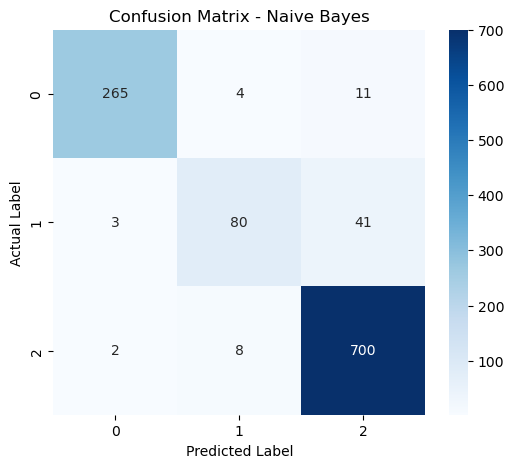

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Define the correct numeric labels
sentiment_labels = [0, 1, 2]  # Assuming 0 = Negative, 1 = Neutral, 2 = Positive

# Compute the confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=sentiment_labels)

# Plot the confusion matrix
#Step 6: Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Load dataset
df = pd.read_csv("byakh.csv")

# Extract text and labels
X_text = df["review"]  # Assuming the 'review' column contains text
y = df["Sentiment"]  # Assuming the 'Sentiment' column contains labels

# Convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_text)

# Initialize models
nb_model = MultinomialNB()
svm_model = SVC(kernel="linear", probability=True)

# Perform 5-fold cross-validation
nb_scores = cross_val_score(nb_model, X, y, cv=5, scoring="accuracy")
svm_scores = cross_val_score(svm_model, X, y, cv=5, scoring="accuracy")

# Display results
print(f"Naïve Bayes Cross-Validation Accuracy: {np.mean(nb_scores):.4f} ± {np.std(nb_scores):.4f}")
print(f"SVM Cross-Validation Accuracy: {np.mean(svm_scores):.4f} ± {np.std(svm_scores):.4f}")


Naïve Bayes Cross-Validation Accuracy: 0.7724 ± 0.0098
SVM Cross-Validation Accuracy: 0.8360 ± 0.0061


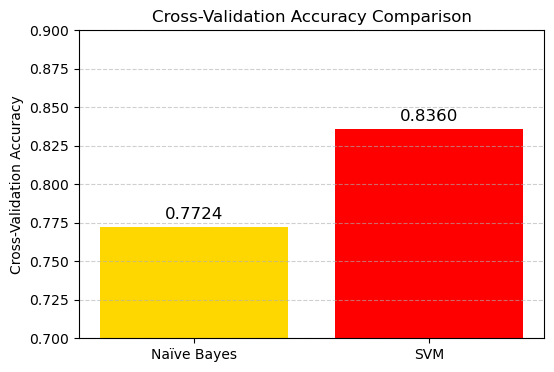

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# Cross-validation results
models = ["Naïve Bayes", "SVM"]
accuracies = [0.7724, 0.8360]  # Mean accuracy
std_devs = [0.0098, 0.0061]  # Standard deviation

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, capsize=5, color=["gold", "red"])

# Labels and title
plt.ylabel("Cross-Validation Accuracy")
plt.title("Cross-Validation Accuracy Comparison")
plt.ylim(0.7, 0.9)  # Adjusting the y-axis for better visibility
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.4f}", ha="center", fontsize=12)
plt.savefig('SD.png', dpi=300)

plt.show()



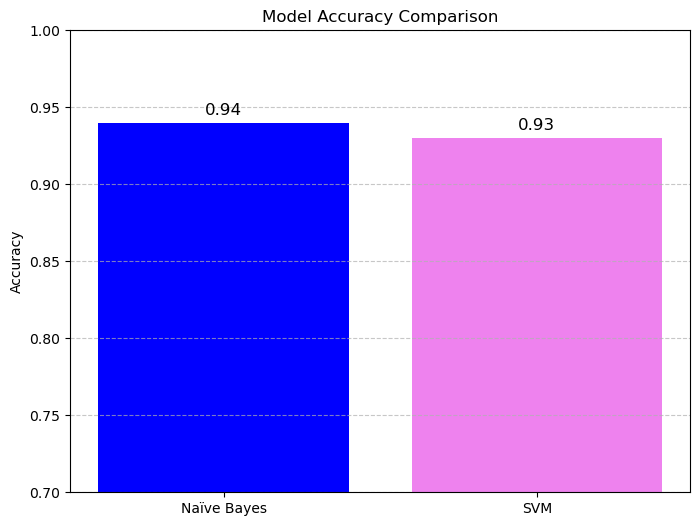

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Create a folder to save the image
os.makedirs("saved_images", exist_ok=True)

# Accuracy values
models = ["Naïve Bayes", "SVM"]
accuracies = [0.94, 0.93]  # Replace with your actual values

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, capsize=5, color=['blue', 'violet'])

# Labels and title
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.7, 1)  # Adjust limits if needed
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.2f}", ha="center", fontsize=12)

# Save the figure before showing it
plt.savefig("saved_images/comparison.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
import joblib

# Save Naïve Bayes model
joblib.dump(nb_model, "naive_bayes_model.pkl")

# Save SVM model
joblib.dump(svm_model, "svm_model.pkl")

# Save the TF-IDF Vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Models and vectorizer saved successfully!")


In [ ]:
# Load Naïve Bayes model
nb_model = joblib.load("Naive_bayes_model.pkl")

# Load SVM model
svm_model = joblib.load("Svm_model.pkl")

# Load the TF-IDF Vectorizer
vectorizer = joblib.load("Tfidf_vectorizer.pkl")

print("Models and vectorizer loaded successfully!")


In [ ]:
import joblib
from sklearn.svm import SVC

# Assume X_train and y_train are your training data
svm_model = SVC(probability=True)  # Ensure probability=True if needed
svm_model.fit(X_train, y_train)  # Train the model

# Save the trained model
joblib.dump(svm_model, "Svm_model.pkl")
